In [71]:
from scipy.optimize import minimize, NonlinearConstraint
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ahu_model import *

In [127]:
damper_load_adj = 0 # Or other reasonable values. Default 0
fan_load_adj = 1 # Or other reasonable values. Default 1
fan_hp = 15 # or other reasonable values. Default to 15
fan_eff = 0.9 # takes values in range [0,1]. Default to 0.9
pump_hp = 25 # or other reasonable values. Default to 25
pump_eff = 0.9 # takes values in range [0,1]. Default to 0.9

def func_obj(x):
    """
    static = x[0]
    T_sa = x[1]
    """
    fan_speed = (28.345*x[0]**0.3412*fan_load_adj)/60 # fan_speed
    pump_speed = (0.6) if x[1] >= (60 - (x[0] - 1.5) * 10) else (0.0015*(x[1] + (x[0] - 1.5) * 10)**2 - 0.1845*(x[1] + (x[0] - 1.5) * 10) + 6.2675) # pump_speed
    fan_power = (1.0608*fan_speed**3 - 0.1222*fan_speed**2 + 0.0684*fan_speed + 0.0022)*fan_hp*0.7457/fan_eff # default model
    pump_power = (1.0608*pump_speed**3 - 0.1222*pump_speed**2 + 0.0684*pump_speed + 0.0022)*pump_hp*0.7457/pump_eff # pump_power
    return fan_power + pump_power

constraint_funcs = {
    'pos_damper': lambda x: -0.221*x[0]**3 + 1.1788*x[0]**2 - 2.1134*x[0] + 1.6964 + damper_load_adj,
    'fan_speed': lambda x: (28.345*x[0]**0.3412*fan_load_adj)/60,
    'pump_speed': lambda x: (0.6) if x[1] >= (60 - (x[0] - 1.5) * 10) else (0.0015*(x[1] + (x[0] - 1.5) * 10)**2 - 0.1845*(x[1] + (x[0] - 1.5) * 10) + 6.2675)
}

nonlin_constraints = [
    NonlinearConstraint(fun=constraint_funcs['pos_damper'], lb=-np.inf, ub=1.0),
    NonlinearConstraint(fun=constraint_funcs['fan_speed'], lb=0.15, ub=1.0),
    NonlinearConstraint(fun=constraint_funcs['pump_speed'], lb=0.3, ub=1.0)
]

In [128]:
# Minimize the objective function using SLSQP bounds on x1 are 0.3 - 2.5 and x2 are 55 - 70
res = minimize(func_obj, [.45, 70], method='SLSQP', bounds=[(0.3, 2.5), (55, 70)], constraints=nonlin_constraints)

In [129]:
print(f"Minimal Total Power: {round(res.fun, 5)} kW")
print(f"Optimal Static Pressure Setpoint: {round(res.x[0], 5)}")
print(f"Optimal Supply Air Temperature: {round(res.x[1], 5)}")

Minimal Total Power: 5.48386 kW
Optimal Static Pressure Setpoint: 0.44958
Optimal Supply Air Temperature: 70.0


In [206]:

x1 = np.linspace(0, 5, 500)
x2 = np.linspace(50, 75, 500)
X1, X2 = np.meshgrid(x1, x2)
results = np.array([func_obj([x, y]) for x, y in zip(np.ravel(X1), np.ravel(X2))])
Z = results.reshape(X1.shape)
x_ = []
y_ = []
f_ = []
# Loop through all values in x1
for i, static in enumerate(x1.reshape(-1, 1)):
    # Loop through all values in x2
    for j, T_sa in enumerate(x2.reshape(-1, 1)):
        # get the pump speed
        pump_speed = pump_speed_from_Tsa_static(T_sa, static)
        damper_pos = damper_pos_from_static(static)
        fan_speed = fan_speed_from_static(static)
        func_value = func_obj([static, T_sa])
        if (0.3 < pump_speed < 1) & (0.3 < static < 2.5) & (55 < T_sa < 70) & (damper_pos < 1) & (0.15 < fan_speed < 1):
            x_.append(static)
            y_.append(T_sa)
            f_.append(func_value)

Text(0.5, 1.0, 'Contour Plot for Optimization of AHU Power')

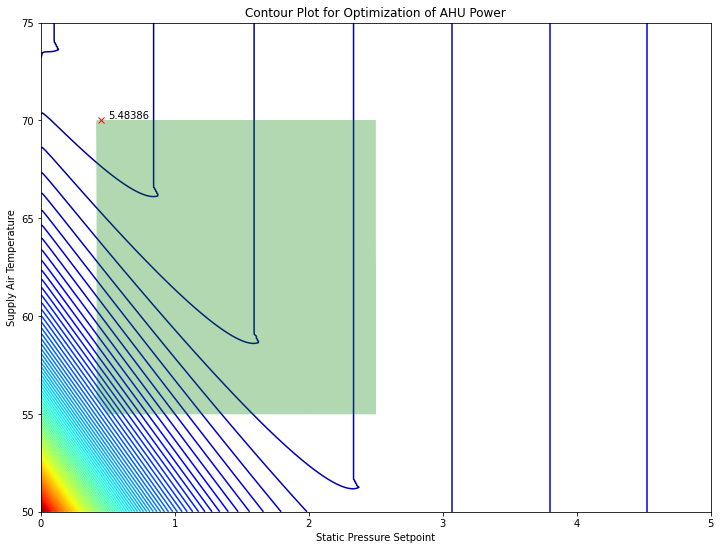

In [217]:
plt.contour(X1, X2, Z, 100, cmap='jet')
plt.axis([0,5,50,75])
plt.plot(x_, y_, alpha = 0.3, c='green')
plt.plot(res.x[0], res.x[1], 'x', c='red')
plt.text(res.x[0]+0.05, res.x[1]+0.1, str(round(res.fun, 5)))
plt.xlabel('Static Pressure Setpoint')
plt.ylabel('Supply Air Temperature')
plt.title('Contour Plot for Optimization of AHU Power')

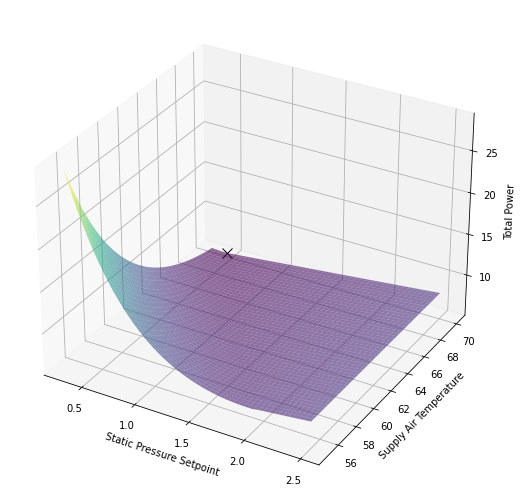

In [218]:
# Create a 3D plot of the objective function
plt.rcParams['figure.figsize'] = (12, 9)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.3, 2.5, 100)
y = np.linspace(55, 70, 100)
X, Y = np.meshgrid(x, y)
results = np.array([func_obj([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = results.reshape(X.shape)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
ax.set_xlabel('Static Pressure Setpoint')
ax.set_ylabel('Supply Air Temperature')
ax.set_zlabel('Total Power')
# plot an x at .45, 70, 5.5
ax.plot([res.x[0]], [res.x[1]], [res.fun], 'x', color='black', markersize=10)
plt.show()
